# Kaggle Digit Recognizer

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *
from fastai.plots import *

In [3]:
#arch = resnet34
#arch = vgg16
#arch = resnext50
arch = resnext101
sz = 64
PATH = 'data/mnistasjpg/'

In [4]:
def get_rnd(path): xs = glob(f'{path}/*.*'); return xs[random.randint(0, len(xs) - 1)]

In [5]:
classes = os.listdir(PATH + 'train')

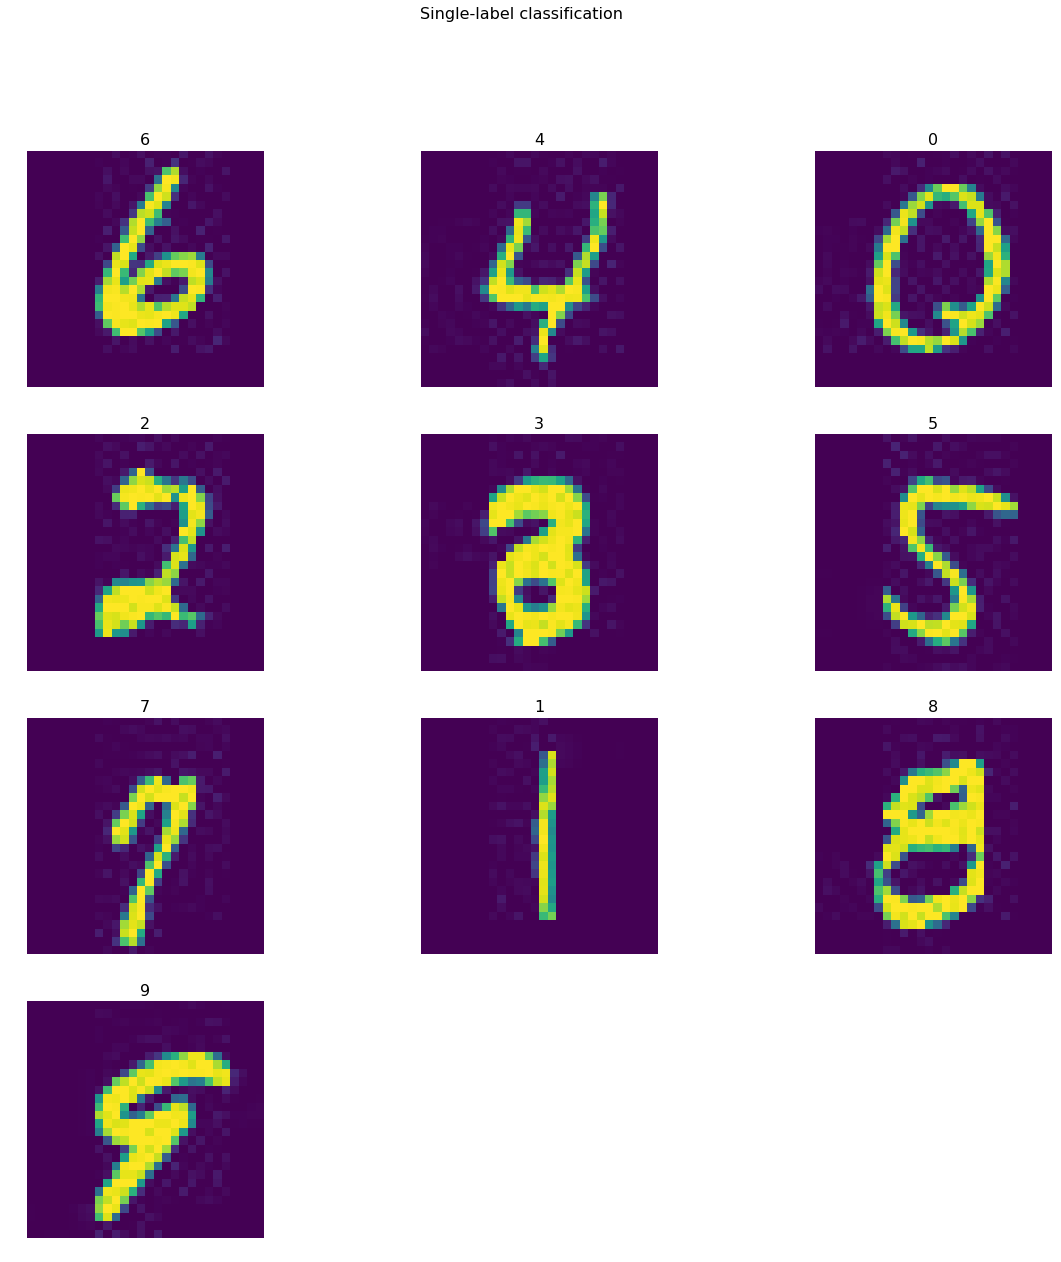

In [6]:
list_paths = [get_rnd(PATH + 'train/' + x) for x in classes]
plots_from_files(list_paths, titles=classes, maintitle="Single-label classification", rows=4, figsize=(20, 20))

In [7]:
def get_val(PATH, classes):
    """
    generate validation set, use once only!
    """
    for c in classes:
        vpath = f'{PATH}valid/{c}/'.replace(' ', '\\ ')
        !mkdir -p {vpath}
        xs = np.array(glob(f'{PATH}train/{c}/*.*'))
        n = len(xs)
        val_idxs = get_cv_idxs(n)
        for f in xs[val_idxs]:
            g = f.replace(' ', '\\ ')
            h = g.replace('train', 'valid')
            !mv {g} {h}

In [8]:
for c in classes:
    vpath = f'{PATH}valid/{c}/'
    tpath = f'{PATH}train/{c}/'
    print(len(glob(vpath + '/*.*')) / len(glob(tpath + '/*.*')))

0.24984894259818732
0.24984653161448742
0.249848759830611
0.24985038898862957
0.24992818155702384
0.25
0.24992899744390798
0.2497331910352188
0.24976930175330667
0.24977618621307074


In [9]:
def getdata(sz):
    tfms = tfms_from_model(arch, sz, max_zoom=1.05)
    return ImageClassifierData.from_paths(PATH, tfms=tfms, test_name='test')

In [10]:
data = getdata(sz)

In [11]:
size_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

(array([    0.,     0.,     0.,     0.,     0., 33604.,     0.,     0.,     0.,     0.]),
 array([27.5, 27.6, 27.7, 27.8, 27.9, 28. , 28.1, 28.2, 28.3, 28.4, 28.5]),
 <a list of 10 Patch objects>)

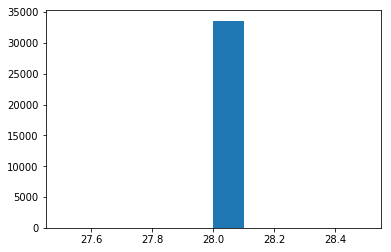

In [12]:
plt.hist(row_sz)

In [13]:
learn = ConvLearner.pretrained(arch, data)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 83%|████████▎ | 438/526 [00:33<00:06, 13.03it/s, loss=2.54] 

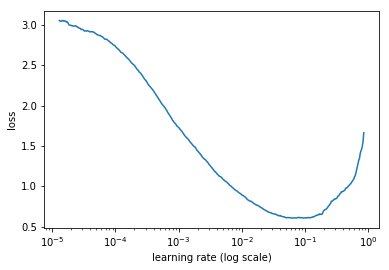

In [14]:
lrf = learn.lr_find()
learn.sched.plot()

In [15]:
lr = 0.02

In [16]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  5%|▌         | 28/526 [00:05<01:43,  4.80it/s, loss=2.69]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.347638   0.229459   0.928109  
    1      0.269823   0.178109   0.940775                    
    2      0.254555   0.157659   0.948587                    
    3      0.22594    0.154724   0.948824                    
    4      0.190616   0.134493   0.95782                     
    5      0.164463   0.125446   0.958886                    
    6      0.210663   0.125004   0.958531                    



[0.1250035, 0.9585306188373854]

In [17]:
lrs = np.array([lr/100, lr/10, lr])

In [18]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.056587   0.031036   0.990175  
    1      0.09847    0.02846    0.991359                     
    2      0.072399   0.022842   0.993253                     
    3      0.035986   0.022469   0.99349                      
    4      0.063595   0.026908   0.991951                     
    5      0.06661    0.025769   0.993963                      
    6      0.008774   0.022469   0.9942                        



In [19]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), axis=0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9934492615531205, 0.02203822473010548)

In [20]:
preds = np.argmax(probs, axis=1)

[[823   0   0   0   0   0   2   0   1   0]
 [  0 936   0   0   0   0   0   0   0   0]
 [  0   0 831   0   0   0   0   3   1   0]
 [  0   0   2 863   0   1   0   2   2   0]
 [  2   0   0   0 808   0   0   0   0   4]
 [  0   0   0   2   0 750   2   0   4   1]
 [  0   0   0   0   4   1 822   0   0   0]
 [  0   2   1   0   1   0   0 875   0   1]
 [  0   1   1   2   0   0   0   0 808   0]
 [  3   0   2   0   3   0   0   1   3 825]]


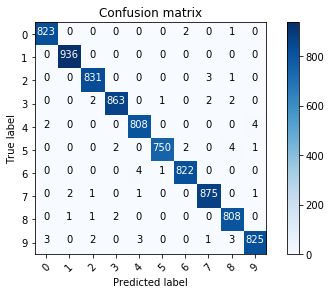

In [21]:
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

In [22]:
log_preds, y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds), axis=0)

In [23]:
preds = np.argmax(probs, axis=1)
preds_c = [data.classes[x] for x in preds]

In [24]:
data.test_ds.fnames[:4]

['test/img_20844.jpg',
 'test/img_8497.jpg',
 'test/img_3738.jpg',
 'test/img_2953.jpg']

In [25]:
testnames = [s[9:-4] for s in data.test_ds.fnames]
df = pd.DataFrame({'ImageId': testnames, 'Label': preds_c}, dtype=np.int32)
df.sort_values(by=['ImageId']).to_csv(PATH + 'submit.csv', index=False)

In [26]:
!kaggle competitions submit -c digit-recognizer -f {PATH}submit.csv -m 'submission with fastai/resnext101'

Successfully submitted to Digit Recognizer